# Data Loading

In [1]:
import pandas as pd

df = pd.read_csv("../data/Housing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [2]:
df['bedrooms'].value_counts()

bedrooms
3    300
2    136
4     95
5     10
6      2
1      2
Name: count, dtype: int64

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [4]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [5]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [6]:
df.duplicated().sum()

np.int64(0)

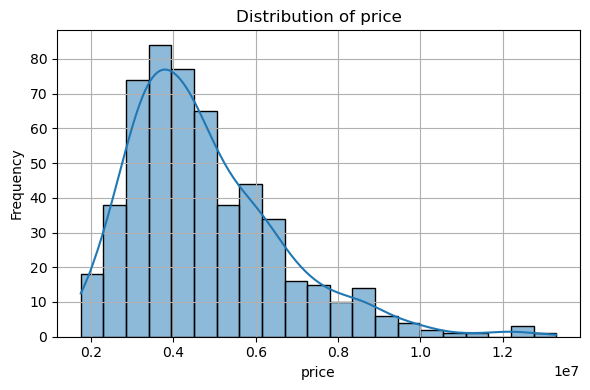

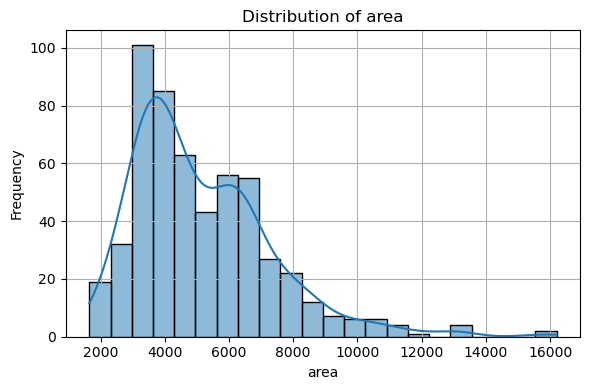

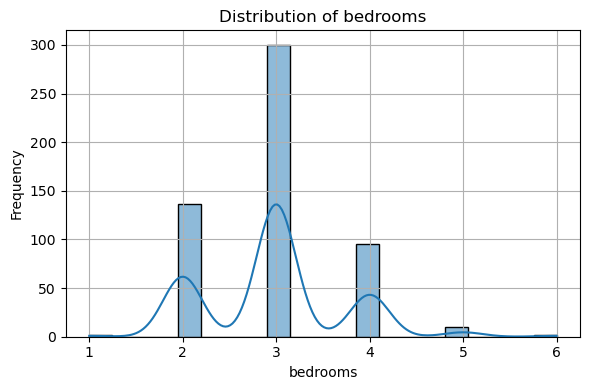

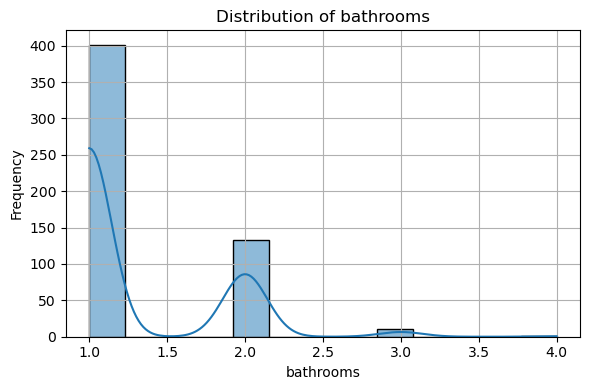

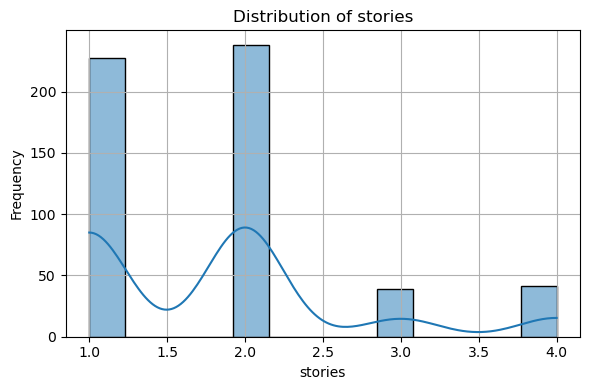

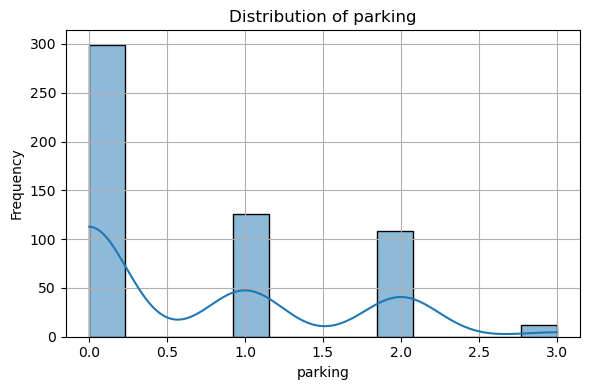

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [8]:
import numpy as np

df['area_log'] = np.log1p(df['area'])

df.drop(columns=['area'], inplace=True)

In [9]:
def detect_outliers_iqr(df, columns):
    outlier_indices = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_indices[col] = outliers.index.tolist()
    return outlier_indices

numerical_cols = ['area_log', 'bedrooms', 'bathrooms', 'stories', 'parking']
outliers = detect_outliers_iqr(df, numerical_cols)
for col, indices in outliers.items():
    print(f"Outliers in {col}: {len(indices)}")

Outliers in area_log: 2
Outliers in bedrooms: 12
Outliers in bathrooms: 1
Outliers in stories: 41
Outliers in parking: 12


In [10]:
def cap_outliers_iqr(df, columns):
    df_capped = df.copy()
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        df_capped[col] = df[col].clip(lower=lower, upper=upper)
        
        print(f"{col}: capped below {lower:.2f} and above {upper:.2f}")
    
    return df_capped
df_capped = cap_outliers_iqr(df, numerical_cols)

area_log: capped below 7.34 and above 9.61
bedrooms: capped below 0.50 and above 4.50
bathrooms: capped below -0.50 and above 3.50
stories: capped below -0.50 and above 3.50
parking: capped below -1.50 and above 2.50


# Train Test Split

In [11]:
from sklearn.model_selection import train_test_split

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Scaling and Encoding

In [12]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat = [col for col in X.columns if X[col].dtype == 'object']
num = [col for col in X.columns if X[col].dtype != 'object']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num])
X_test_scaled = scaler.transform(X_test[num])

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(X_train[cat])
X_test_ohe = ohe.transform(X_test[cat])

ohe_columns = ohe.get_feature_names_out(cat)

X_train_final = pd.DataFrame(X_train_scaled, columns=num, index=X_train.index)
X_test_final = pd.DataFrame(X_test_scaled, columns=num, index=X_test.index)

X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe_columns, index=X_train.index)
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=ohe_columns, index=X_test.index)

X_train_processed = pd.concat([X_train_final, X_train_ohe_df], axis=1)
X_test_processed = pd.concat([X_test_final, X_test_ohe_df], axis=1)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [13]:
import os
import joblib

os.makedirs("models", exist_ok=True)

joblib.dump(scaler, "models/scaler.pkl")

joblib.dump(ohe, "models/encoder.pkl")

print("Scaler and encoder saved successfully in the 'models/' directory.")

Scaler and encoder saved successfully in the 'models/' directory.


# Model Training and Evaluation

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model = LinearRegression()
model.fit(X_train_processed, y_train_log)

LinearRegression()

In [15]:
y_pred_log = model.predict(X_test_processed)

y_pred = np.expm1(y_pred_log)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 743232.85
MSE: 1235846885936.54
R² Score: 0.77


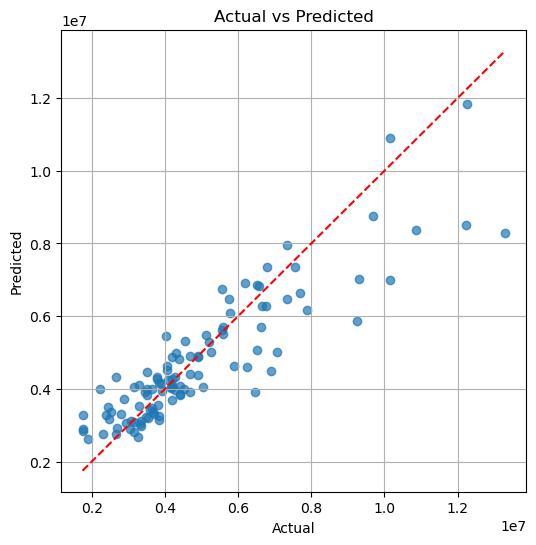

In [16]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()

In [17]:
coeff_df = pd.DataFrame({
    "Feature": X_train_processed.columns,
    "Coefficient": model.coef_
})

print(coeff_df.sort_values(by="Coefficient", ascending=False))

                            Feature  Coefficient
4                          area_log     0.109793
12              hotwaterheating_yes     0.094004
14              airconditioning_yes     0.082552
2                           stories     0.078746
1                         bathrooms     0.069933
16                     prefarea_yes     0.059638
17       furnishingstatus_furnished     0.044109
6                      mainroad_yes     0.042672
8                     guestroom_yes     0.039850
10                     basement_yes     0.038500
18  furnishingstatus_semi-furnished     0.036975
3                           parking     0.028996
0                          bedrooms     0.023128
9                       basement_no    -0.038500
7                      guestroom_no    -0.039850
5                       mainroad_no    -0.042672
15                      prefarea_no    -0.059638
19     furnishingstatus_unfurnished    -0.081085
13               airconditioning_no    -0.082552
11               hot

# Model Saving

In [18]:
os.makedirs("models", exist_ok=True)

joblib.dump(model, "models/linear_regression_model.pkl")

['models/linear_regression_model.pkl']